# Machine Learning : Country access to electricity

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [81]:
df = pd.read_csv('API_EN.GHG.CO2.MT.CE.AR5_DS2_en_csv_v2_6117.csv', sep = ';')
df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density (P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60.0,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60.0,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60.0,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60.0,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60.0,652230.0,33.93911,67.709953


Predict future CO₂ emissions (Value_co2_emissions_kt_by_country) and Renewable energy share in total final energy consumption (%) for each country

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3649 non-null   object 
 1   Year                                                              3649 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2718 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3455 non-null   float64
 7   Electricity from fossil fuels (TW

## 2. Dataframe cleaning

### A. Volume of data 

As we're going to do time series prediction we need first to be sure there is enough data, year in our case, to train the model.

In [83]:
df.groupby("Entity")["Year"].count().sort_values()

Entity
French Guiana     1
South Sudan       8
Montenegro       14
Serbia           14
Afghanistan      21
                 ..
Georgia          21
Germany          21
Ghana            21
Ethiopia         21
Zimbabwe         21
Name: Year, Length: 176, dtype: int64

We can see that only 4 country don't have the twenty year background. French Guiana obviously doesn't have enough volume. We take out South Sudan too. We choose to keep country over 14 years data background. 

In [84]:
df = df[~df['Entity'].isin(['French Guiana', 'South Sudan'])]
df.groupby("Entity")["Year"].count().sort_values()

Entity
Montenegro       14
Serbia           14
Afghanistan      21
New Caledonia    21
New Zealand      21
                 ..
Georgia          21
Germany          21
Ghana            21
Ethiopia         21
Zimbabwe         21
Name: Year, Length: 174, dtype: int64

### B. NAN values and Duplicates

In [85]:
df.duplicated(subset=['Entity', 'Year']).sum()

0

There's no duplicated data.

In [86]:
df_nan = df.isna().sum() / len(df) * 100
df_nan.sort_values()

Entity                                                               0.000000
Land Area(Km2)                                                       0.000000
Density (P/Km2)                                                      0.000000
Primary energy consumption per capita (kWh/person)                   0.000000
Latitude                                                             0.000000
Longitude                                                            0.000000
Year                                                                 0.000000
Access to electricity (% of population)                              0.247253
Electricity from fossil fuels (TWh)                                  0.576923
Electricity from renewables (TWh)                                    0.576923
Low-carbon electricity (% electricity)                               1.153846
Electricity from nuclear (TWh)                                       3.461538
Access to clean fuels for cooking                               

The columns Renewables (% equivalent primary energy) and Financial flows to developing countries have more than half of there data missing so we drop them

In [87]:
df = df.drop(columns = ['Renewables (% equivalent primary energy)', 'Financial flows to developing countries (US $)' ])
df

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,gdp_growth,gdp_per_capita,Density (P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,NaN,NaN,60.0,652230.0,33.939110,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,NaN,NaN,60.0,652230.0,33.939110,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,NaN,179.426579,60.0,652230.0,33.939110,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,8.832278,190.683814,60.0,652230.0,33.939110,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,1.414118,211.382074,60.0,652230.0,33.939110,67.709953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3644,Zimbabwe,2016,42.561730,29.8,62.88,81.90,3.50,0.0,3.32,48.680350,3227.68020,10.00,11020.000460,0.755869,1464.588957,38.0,390757.0,-19.015438,29.154857
3645,Zimbabwe,2017,44.178635,29.8,62.33,82.46,3.05,0.0,4.30,58.503407,3068.01150,9.51,10340.000150,4.709492,1235.189032,38.0,390757.0,-19.015438,29.154857
3646,Zimbabwe,2018,45.572647,29.9,82.53,80.23,3.73,0.0,5.46,59.412407,3441.98580,9.83,12380.000110,4.824211,1254.642265,38.0,390757.0,-19.015438,29.154857
3647,Zimbabwe,2019,46.781475,30.1,81.40,81.50,3.66,0.0,4.58,55.582527,3003.65530,10.47,11760.000230,-6.144236,1316.740657,38.0,390757.0,-19.015438,29.154857


In [88]:
nan_cols = [
    'Access to electricity (% of population)',
    'Electricity from fossil fuels (TWh)',
    'Electricity from renewables (TWh)',
    'Low-carbon electricity (% electricity)',
    'Electricity from nuclear (TWh)',
    'Access to clean fuels for cooking',
    'Renewable energy share in the total final energy consumption (%)',
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
    'gdp_per_capita',
    'gdp_growth',
    'Value_co2_emissions_kt_by_country',
    'Renewable-electricity-generating-capacity-per-capita'
]


To manage the rest of the missing data, we take into account both dimensions: time and variables.
If a missing value for a variable corresponds to an isolated year for a country, it is replaced using a moving average based on the previous and the following year.
However, if a variable is entirely missing for a country (there are no observations for any year), we impute it with the average value of that variable across all countries

In [89]:
df = df.sort_values(['Entity', 'Year'])

In [90]:
#Mobile average for each country
for col in nan_cols:
    df[col] = df.groupby('Entity')[col].transform(
        lambda x: x.fillna(x.rolling(window=3, min_periods=1).mean()))

#Global mean of countries for each variable by year
for col in nan_cols:
    df[col] = df.groupby('Year')[col].transform(lambda x: x.fillna(df[col].mean()))


In [91]:
df_nan = df.isna().sum() / len(df) * 100
df_nan.sort_values()

Entity                                                              0.0
Land Area(Km2)                                                      0.0
Density (P/Km2)                                                     0.0
gdp_per_capita                                                      0.0
gdp_growth                                                          0.0
Value_co2_emissions_kt_by_country                                   0.0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         0.0
Primary energy consumption per capita (kWh/person)                  0.0
Latitude                                                            0.0
Low-carbon electricity (% electricity)                              0.0
Electricity from nuclear (TWh)                                      0.0
Electricity from fossil fuels (TWh)                                 0.0
Renewable energy share in the total final energy consumption (%)    0.0
Renewable-electricity-generating-capacity-per-capita            

### C. Inconsitensies

#### Zero

In [92]:
zero_count = (df == 0).sum()
zero_freq = (df == 0).mean() * 100
zero_freq.sort_values()

Entity                                                               0.000000
Land Area(Km2)                                                       0.000000
Density (P/Km2)                                                      0.000000
gdp_per_capita                                                       0.000000
Value_co2_emissions_kt_by_country                                    0.000000
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          0.000000
Latitude                                                             0.000000
Longitude                                                            0.000000
Access to clean fuels for cooking                                    0.000000
Access to electricity (% of population)                              0.000000
Year                                                                 0.000000
gdp_growth                                                           0.027473
Primary energy consumption per capita (kWh/person)              

For the columns with zeros, it makes sense that some countries have zero values, so there is no need to change them.

#### Negative

In [105]:
numeric_cols = df.select_dtypes(include=['number']).columns

(df[numeric_cols] < 0).sum().sort_values()

Year                                                                   0
Land Area(Km2)                                                         0
Density (P/Km2)                                                        0
gdp_per_capita                                                         0
Value_co2_emissions_kt_by_country                                      0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)            0
Low-carbon electricity (% electricity)                                 0
Primary energy consumption per capita (kWh/person)                     0
Electricity from nuclear (TWh)                                         0
Electricity from fossil fuels (TWh)                                    0
Renewable energy share in the total final energy consumption (%)       0
Renewable-electricity-generating-capacity-per-capita                   0
Access to clean fuels for cooking                                      0
Access to electricity (% of population)            

All the variables with negatives data are logical.

#### Percentages
Percentage columns should be between 0 and 100

In [95]:
percent_cols = ["Access to electricity (% of population)","Access to clean fuels for cooking",
                "Low-carbon electricity (% electricity)","Renewable energy share in the total final energy consumption (%)"]

In [96]:
print((df[percent_cols] > 100).sum())
(df[percent_cols] < 0).sum()

Access to electricity (% of population)                             0
Access to clean fuels for cooking                                   0
Low-carbon electricity (% electricity)                              1
Renewable energy share in the total final energy consumption (%)    0
dtype: int64


Access to electricity (% of population)                             0
Access to clean fuels for cooking                                   0
Low-carbon electricity (% electricity)                              0
Renewable energy share in the total final energy consumption (%)    0
dtype: int64

In [97]:
df[df['Low-carbon electricity (% electricity)']>100]

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,gdp_growth,gdp_per_capita,Density (P/Km2),Land Area(Km2),Latitude,Longitude
425,Bhutan,2005,59.808113,47.3,722.57,91.67,0.0,0.0,2.62,100.00001,11119.834,13.61,319.999993,7.287249,1228.432356,20.0,38394.0,27.514162,90.433601


It's probably a little mistake and should be 100%, as we know Bhutan produces more than 99% of it's electricity with hydropower plants, and the rest comes from green means like wind or solar)

(cf. https://www.worldometers.info/electricity/bhutan-electricity/)

In [98]:
# All values higher than 100 are forced to 100
df.loc[df['Low-carbon electricity (% electricity)'] > 100, 'Low-carbon electricity (% electricity)'] = 100
(df[percent_cols] > 100).sum()

Access to electricity (% of population)                             0
Access to clean fuels for cooking                                   0
Low-carbon electricity (% electricity)                              0
Renewable energy share in the total final energy consumption (%)    0
dtype: int64

#### Latitude and longitude
All latitude data should be between ±90 and longitude between ±180

In [106]:
lat = df[(df['Latitude'] < -90) | (df['Latitude'] > 90)]
long = df[(df['Longitude'] < -180) | (df['Longitude'] > 180)]

print('out of range lat : ', len(lat))
print('out of range long : ', len(long))


out of range lat :  0
out of range long :  0


### D. Outliers

In [16]:
df.describe().T.sort_values("max", ascending=False)


,count,mean,std,min,25%,50%,75%,max
Financial flows to developing countries (US $),1554.0,9.456904e+07,2.986772e+08,0.000000,262500.000000,5.690000e+06,5.567750e+07,5.202310e+09
Value_co2_emissions_kt_by_country,3214.0,1.602111e+05,7.744681e+05,10.000000,2059.999943,1.055000e+04,6.090750e+04,1.070722e+07
Land Area(Km2),3640.0,6.331891e+05,1.587261e+06,21.000000,25713.000000,1.176000e+05,5.131200e+05,9.984670e+06
Primary energy consumption per capita (kWh/person),3640.0,2.580241e+04,3.479571e+04,0.000000,3135.203700,1.321183e+04,3.391825e+04,2.625857e+05
gdp_per_capita,3364.0,1.329437e+04,1.971546e+04,111.927225,1338.405525,4.580079e+03,1.577499e+04,1.235142e+05
Electricity from fossil fuels (TWh),3619.0,7.053875e+01,3.484670e+02,0.000000,0.290000,2.980000e+00,2.688000e+01,5.184130e+03
Renewable-electricity-generating-capacity-per-capita,2709.0,1.132540e+02,2.442331e+02,0.000000,3.840000,3.318000e+01,1.123500e+02,3.060190e+03
Electricity from renewables (TWh),3619.0,2.402761e+01,1.045540e+02,0.000000,0.050000,1.480000e+00,9.640000e+00,2.184940e+03
Year,3640.0,2.010027e+03,6.050883e+00,2000.000000,2005.000000,2.010000e+03,2.015000e+03,2.020000e+03
Density\n(P/Km2),3640.0,1.373135e+02,1.684545e+02,1.000000,26.000000,8.200000e+01,2.030000e+02,1.281000e+03


In [107]:
z_scores = df.select_dtypes('number').apply(stats.zscore)
outlier_counts = (abs(z_scores) > 3).sum()
print(outlier_counts.sort_values(ascending=False).head())


Land Area(Km2)                                                 105
Primary energy consumption per capita (kWh/person)             103
gdp_per_capita                                                  86
Energy intensity level of primary energy (MJ/$2017 PPP GDP)     75
Electricity from renewables (TWh)                               73
dtype: int64


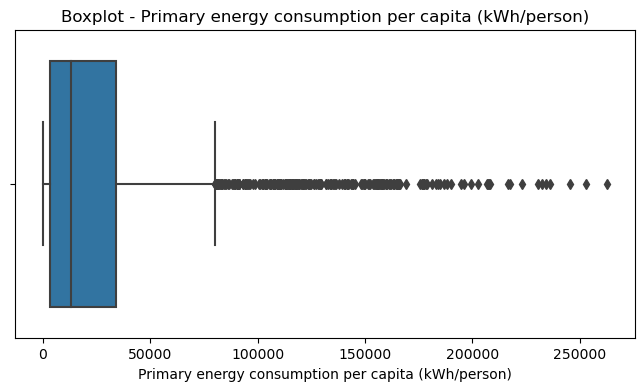

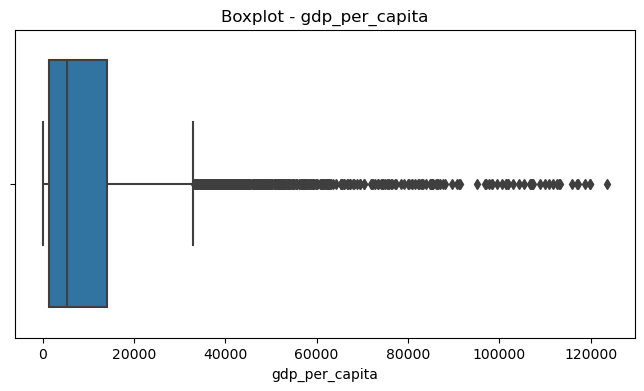

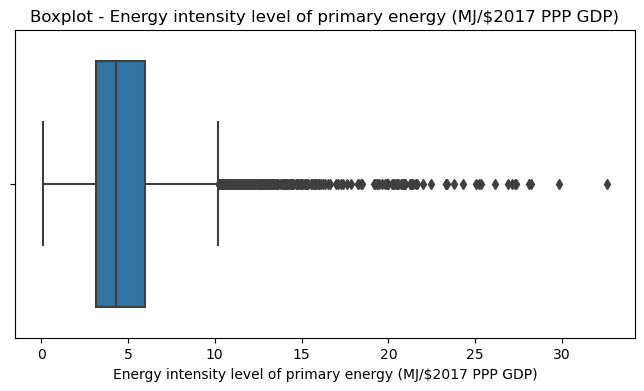

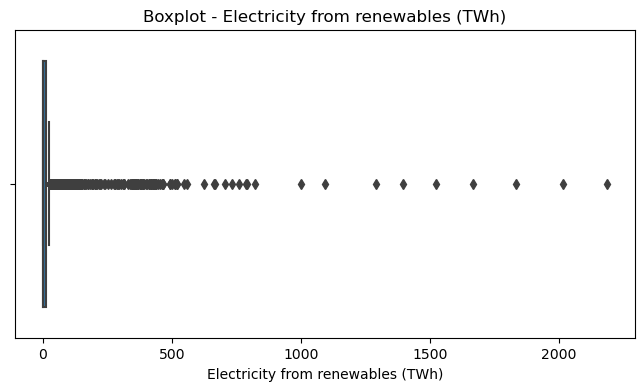

In [109]:
cols_to_check = [    'Primary energy consumption per capita (kWh/person)',    'gdp_per_capita',
                 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',    'Electricity from renewables (TWh)']

for col in cols_to_check:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot - {col}')
    plt.show()


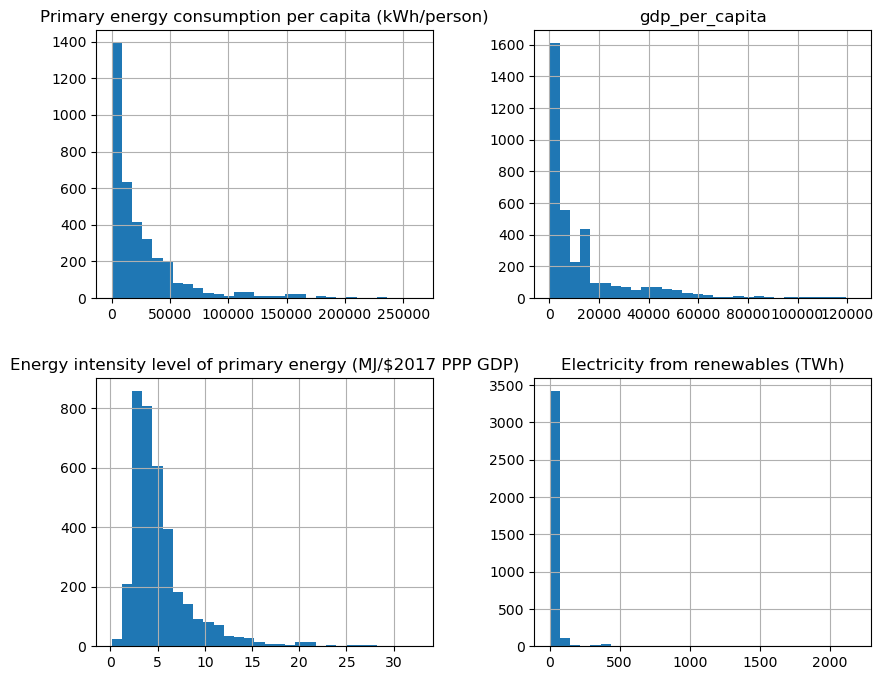

In [113]:
df[cols_to_check].hist(figsize=(10,8), bins=30)
plt.legend
plt.show()


### E. Scaling

In [117]:
num_cols = df.select_dtypes('number').columns.drop(['Year','Density (P/Km2)', 'Land Area(Km2)', 'Latitude', 'Longitude'], errors='ignore')

scaler = StandardScaler()
scaled = scaler.fit_transform(df[num_cols])
df_scaled = pd.DataFrame(scaled, index=df.index, columns=num_cols)
df_scaled = pd.concat([df[['Entity', 'Year', 'Density (P/Km2)', 'Land Area(Km2)', 'Latitude', 'Longitude']], df_scaled], axis=1)
df_scaled


,Entity,Year,Density (P/Km2),Land Area(Km2),Latitude,Longitude,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,gdp_growth,gdp_per_capita,Estimated_Population
0,Afghanistan,2000,60.0,652230.0,33.939110,67.709953,-2.576842,-1.503123,-0.493852,0.417501,-0.202580,-0.187781,-0.227534,0.852201,-0.732944,-1.042955,-0.212689,8.172887e-17,-9.593467e-17,-0.016973
1,Afghanistan,2001,60.0,652230.0,33.939110,67.709953,-2.494997,-1.476845,-0.495561,0.438017,-0.202781,-0.187781,-0.225711,1.403071,-0.734833,-1.014236,-0.212728,8.172887e-17,-9.593467e-17,-0.016973
2,Afghanistan,2002,60.0,652230.0,33.939110,67.709953,-2.317584,-1.450567,-0.497413,0.176686,-0.202666,-0.187781,-0.225136,1.297920,-0.735581,-1.111882,-0.212330,8.172887e-17,-6.920719e-01,-0.016973
3,Afghanistan,2003,60.0,652230.0,33.939110,67.709953,-2.140346,-1.416406,-0.499217,0.137335,-0.202148,-0.187781,-0.224464,0.883393,-0.735032,-1.111882,-0.212078,9.915783e-01,-6.914782e-01,-0.016973
4,Afghanistan,2004,60.0,652230.0,33.939110,67.709953,-1.963203,-1.379617,-0.500831,0.392276,-0.202091,-0.187781,-0.225136,0.763183,-0.735772,-1.169321,-0.212330,-3.736379e-01,-6.903865e-01,-0.016973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3644,Zimbabwe,2016,38.0,390757.0,-19.015438,29.154857,-1.215027,-0.882965,-0.239127,1.658909,-0.192966,-0.187781,-0.198658,0.345640,-0.648868,1.357983,-0.199079,-4.947801e-01,-6.242916e-01,-0.164583
3645,Zimbabwe,2017,38.0,390757.0,-19.015438,29.154857,-1.161253,-0.882965,-0.241738,1.677743,-0.194261,-0.187781,-0.189256,0.633650,-0.653458,1.217258,-0.199981,2.328330e-01,-6.363903e-01,-0.164583
3646,Zimbabwe,2018,38.0,390757.0,-19.015438,29.154857,-1.114892,-0.880337,-0.145848,1.602741,-0.192304,-0.187781,-0.178128,0.660302,-0.642708,1.309160,-0.197275,2.539455e-01,-6.353643e-01,-0.164583
3647,Zimbabwe,2019,38.0,390757.0,-19.015438,29.154857,-1.074690,-0.875081,-0.151212,1.645455,-0.192505,-0.187781,-0.186570,0.548011,-0.655307,1.492964,-0.198098,-1.764655e+00,-6.320892e-01,-0.164583
